In [ ]:
### TODO
#
# - clean the graph to simplify the problem
#   - FORMAT 1
#        - for nodes with multiple transactions between themselves, keep only one directed adge - remove all others. This edge will contain the number of transactions and the average amount of those transactions
#
#
#
#

In [59]:
import pandas as pd
import networkx as nx
import numpy as np

accounts_dir = "../datasets/1K/accounts_digraph_form.csv"
transactions_dir = "../datasets/1K/transactions_digraph_form.csv"

nodes_df = pd.read_csv(accounts_dir)
edges_df = pd.read_csv(transactions_dir)


In [60]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.0.0


In [61]:
nodes_df.head()

,Unnamed: 0,initial_deposit,is_sar,GAW,GAW10,GAW20,Std Degree,first_density,second_density,third_density,small_community,first_strength,second_strength
0,0,96646.86,False,0.000000,0.0,0.0,-0.196067,6.347451,0.109439,1.562386,0,3.292123,0.056761
1,1,80707.36,False,1.825457,0.0,0.0,0.467805,6.873910,0.127295,1.991237,0,2.970092,0.055002
2,2,52101.10,False,0.000000,0.0,0.0,0.430923,6.001972,0.100033,1.280961,0,2.828104,0.047135
3,3,90324.40,False,0.000000,0.0,0.0,2.533186,4.836211,0.053145,0.331338,0,2.302740,0.025305
4,4,91267.86,False,0.000000,0.0,0.0,2.496304,6.001972,0.100033,1.280961,0,2.828104,0.047135


In [62]:
from torch.utils.data import random_split
# Define your graph
#x = torch.nn.functional.normalize(torch.tensor(nodes_df.initial_deposit.to_numpy()).unsqueeze(dim=1),dim=0).to(torch.float32)  # (n x features)
x = torch.nn.functional.normalize(torch.tensor(np.array(nodes_df[['initial_deposit','GAW','GAW10','GAW20','Std Degree','first_density','second_density','third_density','small_community','first_strength','second_strength']].values,dtype='float32')),dim=0).to(torch.float32)  # (n x features)
edge_index =  torch.stack([torch.tensor(edges_df.source.to_numpy()),torch.tensor(edges_df.target.to_numpy())],dim=-1).T  # Define your edge index
#edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['total_tsc_amt','mean_tsc_amt', 'min_tsc_amt', 'max_tsc_amt', 'std_tsc_amt', 'num_of_tscs', 'contains_is_sar_tsc']].values,dtype='float32')),dim=0) # edge features
edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['total_tsc_amt','mean_tsc_amt', 'min_tsc_amt', 'max_tsc_amt', 'std_tsc_amt', 'num_of_tscs']].values,dtype='float32')),dim=0) # edge features
y =  torch.tensor(nodes_df.is_sar.to_numpy().astype(int)) # target values

train_size = int(0.6 * len(y))  # 60% of the dataset for training
val_size = int(0.2 * len(y))    # 20% of the dataset for validation
test_size = len(y) - train_size - val_size  # Remaining 20% for testing

train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

# Create masks for train, validation, and test sets
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_dataset.indices] = True
val_mask[val_dataset.indices] = True
test_mask[test_dataset.indices] = True

In [63]:
from torch_geometric.data import Data
# Load your data into PyTorch Geometric's Data class
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)


In [64]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 1354
Number of edges: 6984
Average node degree: 5.16
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Is weighted: False
Number of training nodes: 812
Training node label rate: 0.60


In [65]:
import torch

from torch.nn import Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

def random_walk_matrix(edge_index, num_nodes: int = None):
    source, target = edge_index[0], edge_index[1]
    in_deg = degree(target, num_nodes=num_nodes)   # D
    edge_weight = 1 / in_deg[target]               # D^-1 A
    return edge_index, edge_weight


class MPNN(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, in_channels2: int):
        super().__init__(aggr="add")                         # "sum" aggregation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin_message = Linear(in_channels, out_channels, # weights 𝚯_1
                                  bias=False)
        self.lin_update = Linear(in_channels2, out_channels,  # weights 𝚯_2
                                 bias=True)                  # the bias vector 𝐛
        
        self.lin1 = Linear(in_channels, out_channels)
        self.lin2 = Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr=None):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        # edge_attr has shape [E, edge_dim]
        #print('x', x.size())
        #print('edge_index', edge_index.size())
        #print('edge_attr', edge_attr.size())

        if edge_attr is None:
            edge_attr = torch.ones((edge_index.size(1), 1), device=x.device)
        # 1. m_j→𝑖 = x_j𝚯_1
        m_ji = self.lin_message(x)  # we can project here with isotropic GNNs
        #m_ji = x  # I decided since we only have one feature, it doesnt make sense to apply a linear to dim 16
        # 2. m_𝑖 = add(ã_ji ⋅ m_j→𝑖)_j∈𝑁(i)
        #print('mji', m_ji.size())
        m_i = self.propagate(edge_index, m=m_ji, edge_attr=edge_attr)
        # 3. h_𝑖 = tanh(x_i𝚯_2 + m_i + 𝐛)
        #print('mi', m_i.size())
        #h_i = torch.tanh(self.lin_update(x) + m_i)
        a = torch.cat([x, m_i], dim=-1)
        #print('ehh')
        #print('here', a.size())
        #print('ehh2')
        
        #print()
        #print('here2', self.lin_update(a).size())
        h_i = torch.tanh(self.lin_update(a))
        return h_i

    def message(self, m_j, edge_attr):
        # x_j has shape [E, in_channels]
        # edge_attr has shape [E, edge_dim]

        #print(m_j)
        #print(m_j.size())
        #print(edge_attr.size())
        #return edge_attr.reshape(-1, 1) * m_j
        #return edge_attr.view(-1, 1) * m_j
        return torch.cat([m_j, edge_attr], dim=-1)
        
        #The code return edge_attr.view(-1, 1) * x_j multiplies the input message x_j with the edge attributes edge_attr.
        #Here, x_j represents the message passed from the node j to its neighbor node i, and edge_attr represents the corresponding edge attribute associated with the edge connecting the nodes i and j.
        #The view(-1, 1) method call is used to reshape edge_attr to have one column and as many rows as there are messages passed between nodes. This is done so that the multiplication operation between x_j and edge_attr can be performed element-wise between the corresponding rows of x_j and edge_attr.
        #The resulting tensor has the same shape as x_j and represents the transformed messages to be aggregated by the receiving node i.

#    def message(self, m_j, edge_weight):
#        return edge_weight.view(-1, 1) * m_j  # ã_ji ⋅ m_j→𝑖


In [72]:
import torch

from torch.nn import Linear

HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 4 #@param

dataset_num_node_features = x.size(1)
dataset_num_edge_features = edge_attr.size(1)
dataset_num_classes = 5

class GNNModel(torch.nn.Module):

    def __init__(self, hidden_size: int,
                 num_layers: int = 1):
        super().__init__()
        torch.manual_seed(12345)

        self.mpnns = torch.nn.ModuleList()
        for l in range(num_layers):
            #in_size = dataset_num_features if l == 0 else hidden_size
            in_size = dataset_num_node_features if l == 0 else hidden_size
            in_size2 = hidden_size + dataset_num_node_features + dataset_num_edge_features if l == 0 else hidden_size*2 + dataset_num_edge_features
            mpnn = MPNN(in_channels=in_size, out_channels=hidden_size, in_channels2=in_size2)
            self.mpnns.append(mpnn)

        self.lin_out = Linear(hidden_size, dataset_num_classes)
    
    def forward(self, x, edge_index, edge_attr=None):
        # Message-passing: transform node features based on neighbors
        for mpnn in self.mpnns:
            #x = mpnn(x, edge_index, edge_weight)
            x = mpnn(x, edge_index, edge_attr=edge_attr)
        # Decoder: post-process extracted features
        out = self.lin_out(x)
        return out

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
print(model)
print_model_size(model)

GNNModel(
  (mpnns): ModuleList(
    (0): MPNN(11, 16)
    (1-3): 3 x MPNN(16, 16)
  )
  (lin_out): Linear(in_features=16, out_features=5, bias=True)
)
Number of model (GNNModel) parameters:      5541


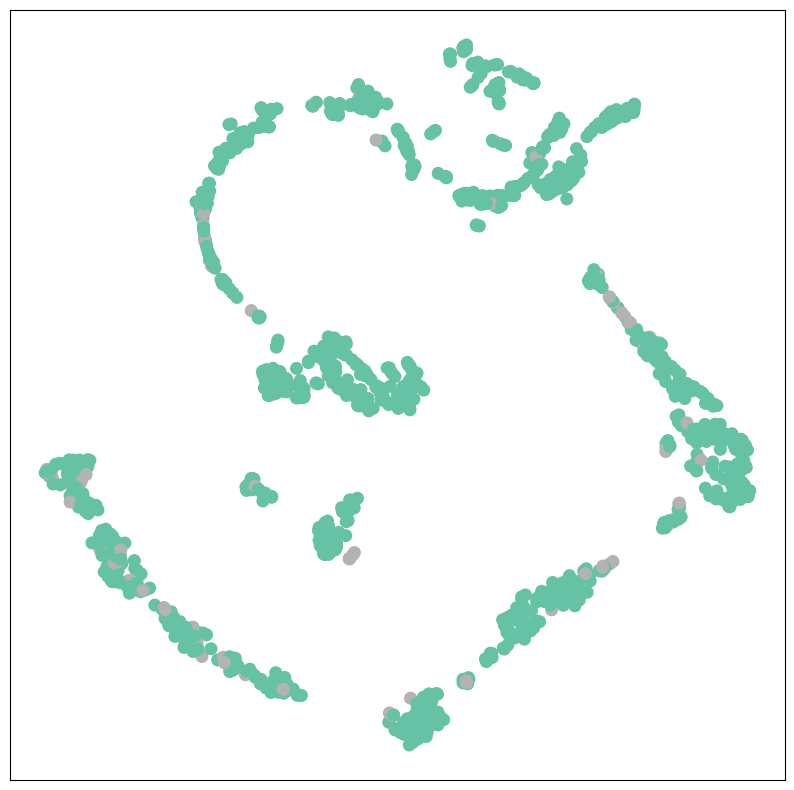

In [73]:
model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
model.eval()

out = model(data.x, data.edge_index, edge_attr=data.edge_attr)
visualize(out, color=data.y)

In [74]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      #out = model(data.x, gso_index, gso_weight)
      out = model(data.x, data.edge_index, data.edge_attr)
      print(len(out[data.train_mask]),len(data.y[data.train_mask]))
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index, data.edge_attr)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

for epoch in range(1, 201):
    train_loss = train()
    val_loss, _, _ = test(data.val_mask)
    print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - '
          f'Validation accuracy: {val_loss * 100:.2f}%')

<IPython.core.display.Javascript object>

812 812
Epoch: 001 - Training loss: 1.8492 - Validation accuracy: 6.67%
812 812
Epoch: 002 - Training loss: 1.6123 - Validation accuracy: 73.70%
812 812
Epoch: 003 - Training loss: 1.2872 - Validation accuracy: 74.81%
812 812
Epoch: 004 - Training loss: 1.0578 - Validation accuracy: 76.30%
812 812
Epoch: 005 - Training loss: 0.8550 - Validation accuracy: 76.30%
812 812
Epoch: 006 - Training loss: 0.7262 - Validation accuracy: 93.33%
812 812
Epoch: 007 - Training loss: 0.6270 - Validation accuracy: 93.33%
812 812
Epoch: 008 - Training loss: 0.5440 - Validation accuracy: 93.33%
812 812
Epoch: 009 - Training loss: 0.4769 - Validation accuracy: 93.33%
812 812
Epoch: 010 - Training loss: 0.4195 - Validation accuracy: 93.33%
812 812
Epoch: 011 - Training loss: 0.3702 - Validation accuracy: 93.33%
812 812
Epoch: 012 - Training loss: 0.3291 - Validation accuracy: 93.33%
812 812
Epoch: 013 - Training loss: 0.2965 - Validation accuracy: 93.33%
812 812
Epoch: 014 - Training loss: 0.2722 - Validat

In [75]:
test_acc, test_out, test_pred  = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(test_pred)


Test Accuracy: 94.85%
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


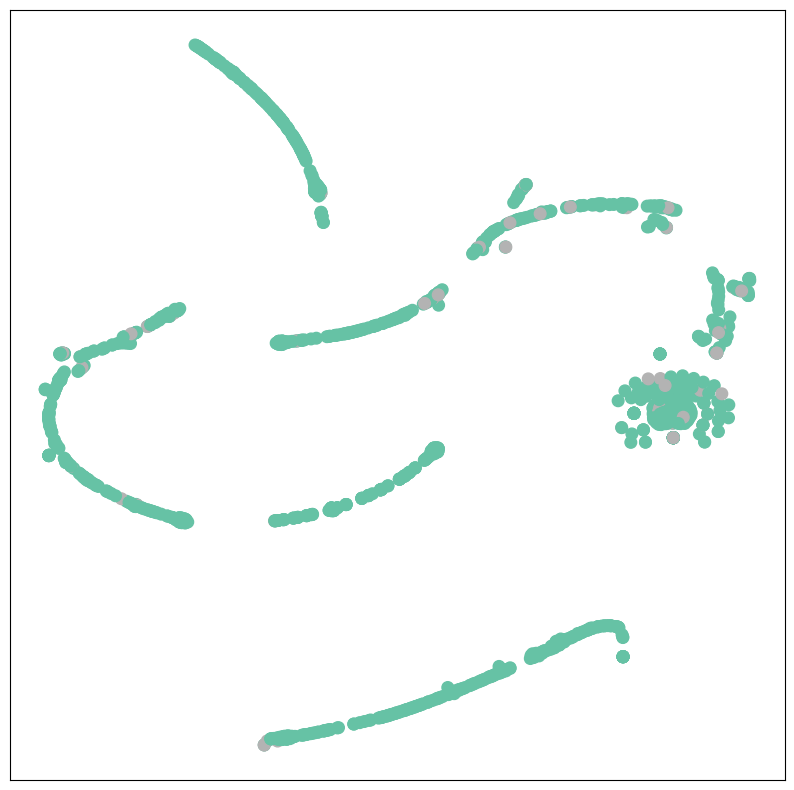

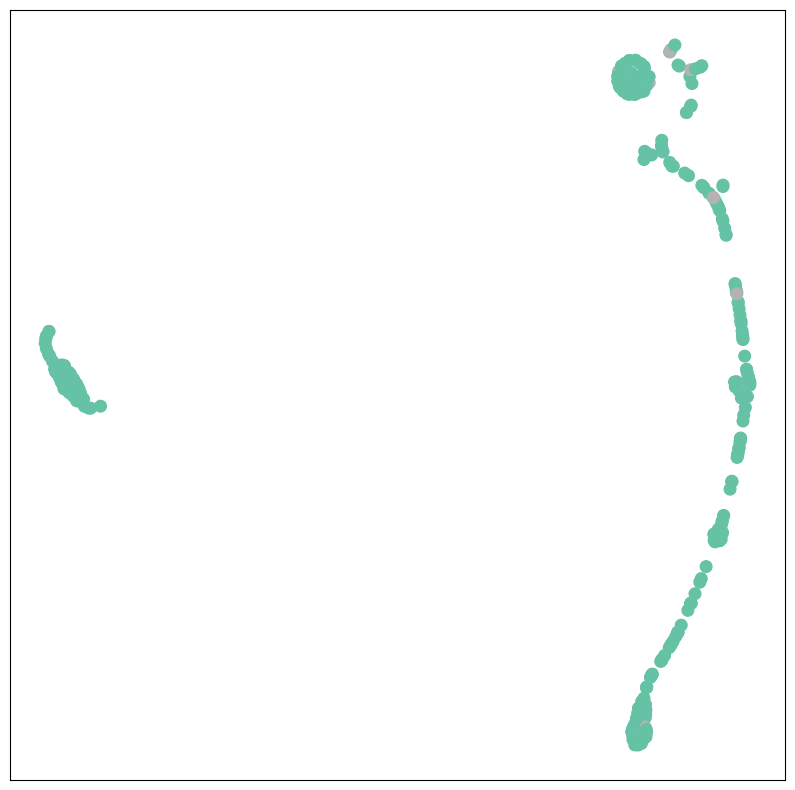

In [76]:
out = model(data.x, data.edge_index, data.edge_attr)
visualize(out, color=data.y)
visualize(out[data.test_mask], color=data.y[data.test_mask])

[0.11351234 0.11350141 0.11350141 0.11350141 0.11350141 0.11350141
 0.11350141 0.11350141 0.11350141 0.11350141 0.11350141 0.11350141
 0.11350141 0.11350141 0.11351105 0.11350229 0.11350644 0.11350414
 0.11350396 0.11350717 0.11350772 0.11160448 0.11351139 0.11351298
 0.11302609 0.11114307 0.09890535 0.0611795  0.08933111 0.05214068
 0.06920312 0.0971342  0.09357028 0.10360873 0.07678312 0.07633641
 0.0963517  0.04992469 0.06483707 0.05665762 0.04222295 0.04077874
 0.05385341 0.04420107 0.04426755 0.05595665 0.04275977 0.04180518
 0.04315742 0.04068229 0.04097547 0.04276399 0.04158632 0.06561969
 0.04917946 0.01931627 0.04513965 0.15938868 0.04176982 0.04167301
 0.01873849 0.04102311 0.05069946 0.04065076 0.05442487 0.04189726
 0.0476576  0.0784567  0.09379654 0.11067384 0.10848597 0.06452964
 0.04560115 0.04072779 0.04246836 0.04826398 0.04877641 0.0422706
 0.04228061 0.15656073 0.02970309 0.05207074 0.16938567 0.046007
 0.21367818 0.01637951 0.04363248 0.04213868 0.05341428 0.0410121

/Users/julienschmidt/anaconda3/envs/GDL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


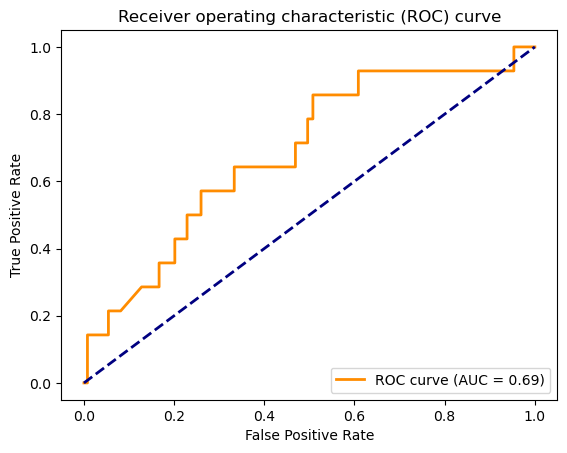

In [71]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import torch.nn.functional as F

y_true = data.y[data.test_mask]
y_pred = softmax_x = F.softmax(test_out, dim=1)
y_pred = y_pred[:, 1].detach().numpy()
print(y_pred)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, test_pred, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [194]:
print(len(data.y[data.test_mask]))
print(len(y_pred))
orig_test_y = data.y[data.test_mask]
b = test_pred == orig_test_y
c = b[orig_test_y == 1]
print(np.sum(c.numpy()/len(c)))

c

290
290
0.5714285714285713


tensor([False,  True, False, False, False,  True,  True, False, False,  True,
         True,  True,  True,  True])